# ***YouTube Data Scraping, Preprocessing and Analysis using Python***

#### ***Setup and Imports***

In [101]:
import time 
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup 
import xlsxwriter


# provide the url of the channel whose data you want to fetch 
urls = [ 
	'https://www.youtube.com/c/CodeWithHarry/videos'
]


times = 0
row = 0
t = v = d = [] 
# Define the path to your ChromeDriver
service = Service('C:/Users/Administrator/My_Journey/chromedriver.exe')
driver = webdriver.Chrome(service=service)

#driver = webdriver.Chrome(executable_path='C:/Users/Administrator/My_Journey/chromedriver.exe') 
# Your scraping logic
for url in urls: 
    driver.get(f'{url}/videos?view=0&sort=p&flow=grid') 
    times = 0  # Reset the scroll counter for each URL
    while times < 5: 
        time.sleep(1) 
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);") 
        times += 1
    content = driver.page_source.encode('utf-8').strip() 
    soup = BeautifulSoup(content, 'lxml')

# Always quit the driver after use
#driver.quit()

#Title 
titles = soup.findAll('yt-formatted-string', id='video-title') 
t =[] 
for i in titles: 
	t.append(i.text) 

#Views 
views = soup.findAll('span', class_='inline-metadata-item style-scope ytd-video-meta-block') 
v = [] 
count = 0
for i in range(len(views)): 
	if i%2 == 0: 
		v.append(views[i].text) 
	else: 
		continue

#Duration 
duration = soup.findAll( 
	'div', class_='badge-shape-wiz__text') 
d = [] 
for i in duration: 
	d.append(i.text) 


#### ***Data Preparation and Organization***

In [102]:
import pandas as pd

# Ensure the lists are of the same length by padding shorter ones with None
max_len = max(len(t), len(v), len(d))

# Pad the shorter lists with None
t.extend([None] * (max_len - len(t)))
v.extend([None] * (max_len - len(v)))
d.extend([None] * (max_len - len(d)))

data = pd.DataFrame({
    'Title': t,
    'Views': v,
    'Duration': d
})

#### ***Preview Data***
*Displays the first 10 rows of the DataFrame to verify data integrity.*

In [103]:
data.head(10)

,Title,Views,Duration
0,5 Essential Python Libraries for Data Analysis...,10K views,8:07
1,What Do Software Engineers Actually Do? (It’s ...,81K views,8:07
2,How I would learn to code (If I could start over),145K views,13:07
3,Ultimate WordPress Tutorial 2025: Build Your S...,59K views,13:07
4,My Last Video | Sigma Web Development Course -...,354K views,13:14
5,Deploying our Next.js App to Vercel | Sigma We...,17K views,13:14
6,How to Scrape the Web Effectively and Efficien...,32K views,41:31
7,[Project] Let's Build a LinkTree Clone in Next...,22K views,41:31
8,[Project] Let's Build a Url Shortener in Next....,23K views,8:27
9,Add AI to your Existing Applications using thi...,27K views,8:27


#### ***Data Cleaning (Views)***
*Cleans the Views column by:*

*Removing non-numeric characters like ***"views"*** and ***"K"****

*Converting values with ***"K"*** to actual numbers.*

In [104]:
data['Views'] = data['Views'].str.replace(" views", "", regex=False)

# Convert 'K' values to numeric, handle non-numeric values gracefully
data['Views'] = data['Views'].apply(lambda x: float(x.replace('K', '')) * 1000 if isinstance(x, str) and 'K' in x 
                                    else float(x) if isinstance(x, str) and x.replace('.', '', 1).isdigit() 
                                    else None)
data.head()


,Title,Views,Duration
0,5 Essential Python Libraries for Data Analysis...,10000.0,8:07
1,What Do Software Engineers Actually Do? (It’s ...,81000.0,8:07
2,How I would learn to code (If I could start over),145000.0,13:07
3,Ultimate WordPress Tutorial 2025: Build Your S...,59000.0,13:07
4,My Last Video | Sigma Web Development Course -...,354000.0,13:14


### ***Convert and Categorize Duration***
*Adds:*

*A new column Duration_seconds, converting video durations to seconds.*

*A Video_Type column to classify videos into categories ***(Mini, Long, Very Long)****

In [105]:
def time_to_seconds(duration):
    try:
        if 'SHORTS' in duration:  # Handle 'SHORTS' case
            return None
        parts = duration.split(':')
        if len(parts) == 2:  # 'hh:mm' or 'mm:ss'
            return int(parts[0]) * 60 + int(parts[1])
        elif len(parts) == 3:  # 'hh:mm:ss'
            return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])
        else:
            return None
    except Exception:
        return None  # In case of any conversion error

# Convert the 'Duration' column to seconds
data['Duration_seconds'] = data['Duration'].apply(time_to_seconds)

# Function to categorize the video based on its duration
def categorize_duration(duration):
    if pd.isna(duration):
        return 'Invalid Duration'
    elif duration <= 900:  # 0 to 900 seconds (15 minutes)
        return 'Mini Video'
    elif duration <= 3600:  # 901 to 3600 seconds (1 hour)
        return 'Long Video'
    else:  # 3601 seconds and above (greater than 1 hour)
        return 'Very Long Video'

# Apply categorization
data['Video_Type'] = data['Duration_seconds'].apply(categorize_duration)
data.head(10)

,Title,Views,Duration,Duration_seconds,Video_Type
0,5 Essential Python Libraries for Data Analysis...,10000.0,8:07,487,Mini Video
1,What Do Software Engineers Actually Do? (It’s ...,81000.0,8:07,487,Mini Video
2,How I would learn to code (If I could start over),145000.0,13:07,787,Mini Video
3,Ultimate WordPress Tutorial 2025: Build Your S...,59000.0,13:07,787,Mini Video
4,My Last Video | Sigma Web Development Course -...,354000.0,13:14,794,Mini Video
5,Deploying our Next.js App to Vercel | Sigma We...,17000.0,13:14,794,Mini Video
6,How to Scrape the Web Effectively and Efficien...,32000.0,41:31,2491,Long Video
7,[Project] Let's Build a LinkTree Clone in Next...,22000.0,41:31,2491,Long Video
8,[Project] Let's Build a Url Shortener in Next....,23000.0,8:27,507,Mini Video
9,Add AI to your Existing Applications using thi...,27000.0,8:27,507,Mini Video


### ***Generate Word Cloud***
*Creates a word cloud visualization from the video titles to highlight frequently used words. The resulting word cloud is saved as an image ***(wordcloud.png)****

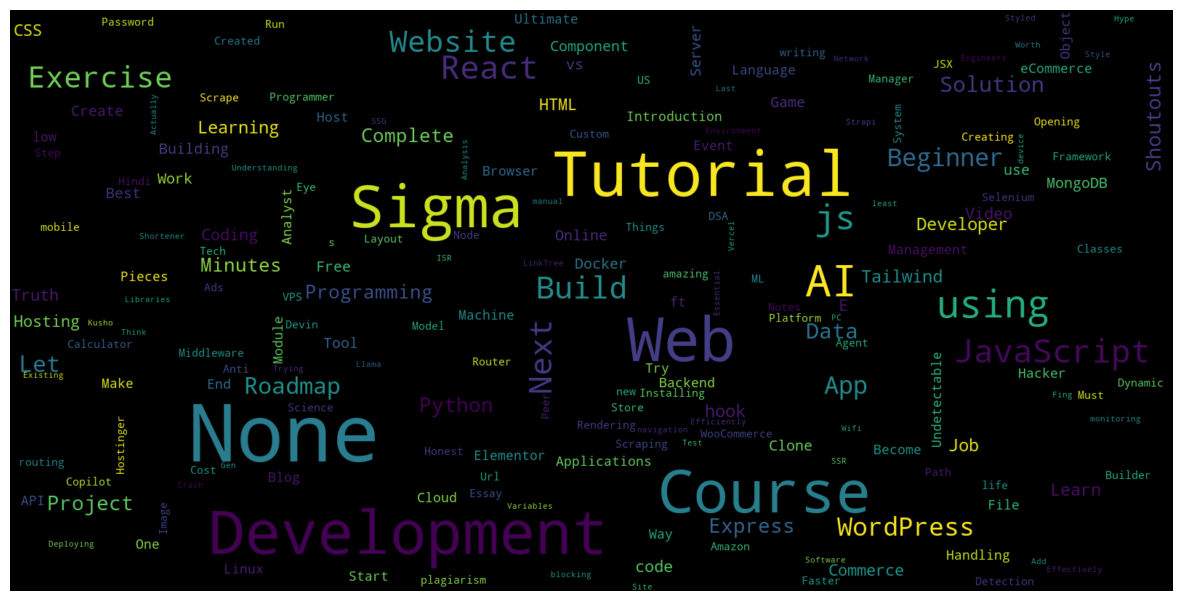

In [113]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import seaborn as sns

consolidated = ' '.join(word for word in data['Title'].astype(str)) 
wordCloud = WordCloud(width=1600, height=800, random_state=21, 
					max_font_size=110, collocations=False) 
plt.figure(figsize=(15, 10)) 
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear') 
plt.axis('off')
wordCloud.to_file("wordcloud.png")
plt.show() 


### ***Visualize Video Categories***
*Uses Seaborn to generate a bar plot that displays the distribution of video types.*

<Axes: xlabel='count', ylabel='Video_Type'>

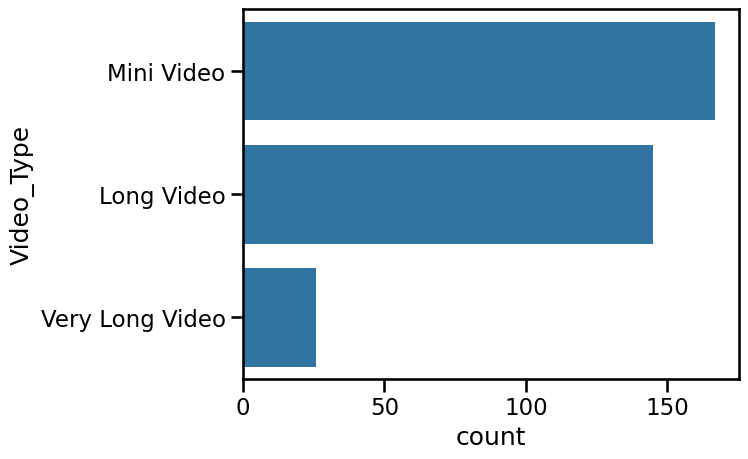

In [107]:
sns.countplot(data['Video_Type'])

### ***Save Results***
*Uncommenting this line saves the cleaned and processed DataFrame as a CSV file.*

In [114]:
#data.to_csv('Code_With_harry_Videos_statistics.csv', index=False)